# HW2 - Transfer Learning with ResNet on STL-10 Dataset

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (27/02/2025)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.9.4)
- Numpy (tested on v1.22.1)
- Torch (tested on v1.12.1)
- torchvision (tested on v0.13.1)

**Deliverables**

This HW notebook is less guided than HW1, on purpose. We expect your code/answers to be assembled in a small PDF report, discussing your implementations, answers to the questions below, along with some discussions about your observations/conclusions. As an additional challenge, you may propose additional implementations that are able to achieve higher accuracy on the test set.

### 0. Prelim: Imports needed and testing for CUDA

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
from resnet50 import *
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

We advise running on GPU and setting up CUDA on your machine as it might drastically speed up the running time for this notebook!

In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


### 1. Prelim: Dataset and Data Augmentation
This assignment focuses on adapting a pre-trained ResNet50 model to a new image classification task using transfer learning. The process involves two main steps:
- Pre-training: First, we will train ResNet50 on the CIFAR-10 dataset using resnet50.py.
- Fine-tuning: Next, we will fine-tune the model using the STL-10 dataset to adapt it to a new domain.

Both CIFAR-10 and STL-10 contain 10 classes, representing airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. However, they differ in image resolution:
- CIFAR-10: 32×32 pixels
- STL-10: 96×96 pixels

**Question 1:**
- Based on the description for the dataset, could you describe what is the machine learning task here (supervised/unsupervised, classification/regression)?

ANSWER: The task here is a supervised learning classification task to classify an image into 10 possible categories.

- How many input features (e.g., image dimensions, channels) and output classes are present?

ANSWER:

Input = (for CIFAR-10) 32x23x3; (for STL-10) 96x96x3, where height x width x channels

Output Classes = 10  

- What is the purpose of the transforms.Resize((224, 224)) operation in the transform variable below? Why is it needed?

ANSWER:

ResNet50 was originally designed for ImageNet, where images have dimensions 224×224×3. Hence, the base model’s architecture expects this input size for correct feature extraction. However, CIFAR-10 images are 32×32, and STL-10 images are 96×96. Therefore, there is a need to standardize input size across datasets. Resizing ensures that both datasets have a uniform input size, preventing shape mismatches in the neural network.

In [3]:
"""Data Preprocessing"""
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

To maintain computational efficiency and reduce execution time, we will use a subset of the STL-10 dataset:
- Training phase: 100 samples per class, resulting in 1,000 training images.
- Testing phase: 50 samples per class, resulting in 500 test images.

In [4]:
# Load the dataset
# (This might take a while as the dataset are quite big)
train_dataset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
train_dataset = torch.utils.data.Subset(train_dataset, [i for i in range(0, 1000)])
test_dataset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = torch.utils.data.Subset(test_dataset, [i for i in range(0, 500)])
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

100%|██████████| 2.64G/2.64G [29:36<00:00, 1.49MB/s]


Train size: 1000, Test size: 500


### 2. Prelim: Our pre-trained Model

We will use a simple pre-trained resnet model, with architecture and trainer stored in *resnet50.py* and weights stored in file *resnet50.data*.
This is a pre-trained model with a simple architecture and its baseline accuracy is 80.2%.

In [5]:
# Load the pretrained model
pretrained_model_weight = "./resnet50.data"
state_dict = torch.load(pretrained_model_weight, map_location=device)
model = resnet50(num_classes=10)
model.load_state_dict(state_dict, strict=False)
print(model)

ResNet(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

### 3. Transfer Learning Strategies

In this assignment, we explore two transfer learning strategies to adapt a pre-trained ResNet50 model for the STL-10 dataset:
1. Freeze all layers of ResNet50 except the final linear layer.
2. Fine-tune the entire pre-trained model.

**Question 2:** How would you modify the architecture to work with the STL-10 Dataset with these two strategies? Write code to replace the missing part and show your code in your report.

In [8]:
# model1: only train fc
model1 = resnet50(num_classes=10)
model1.load_state_dict(state_dict, strict=False)
model1.to(device)
for param in model1.parameters():
  param.requires_grad = False
for param in model1.fc.parameters():
  param.requires_grad = True

optimizer1 = optim.SGD(model1.fc.parameters(), lr=0.005, momentum=0.9)

# model2: fine-tune the entire model
model2 = resnet50(num_classes=10)
model2.load_state_dict(state_dict, strict=False)
model2.to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
for param in model2.parameters():
  param.requires_grad = True


**Question 3:** Next, we will use two transfer learning strategies to retrain and test the models on the new dataset. Fill in the missing parts and show your code in your report.

In [10]:
num_epochs = 50
batch_size = 32

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# loss
criterion = nn.CrossEntropyLoss()

# log
train_losses = {}
val_losses = {}
val_accuracies = {}

def train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs):
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(test_loader)
        accuracy = correct/total
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(accuracy)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.4%}")

    return train_loss_list, val_loss_list, val_acc_list

### 4. Visualization and Analysis
**Question 4:** Plot training/validation loss curves for both strategies.
- Compare their final test accuracies. Which strategy is more effective? Why or why not?
- Does unfreezing more layers always improve performance? Why or why not?


Training Strategy 1
Epoch [1/50], Train Loss: 2.5476, Val Loss: 2.4552, Val Acc: 16.8000%
Epoch [2/50], Train Loss: 2.2178, Val Loss: 2.0970, Val Acc: 22.0000%
Epoch [3/50], Train Loss: 2.0903, Val Loss: 1.9733, Val Acc: 26.6000%
Epoch [4/50], Train Loss: 1.9822, Val Loss: 1.9010, Val Acc: 31.6000%
Epoch [5/50], Train Loss: 1.9045, Val Loss: 1.8732, Val Acc: 31.8000%
Epoch [6/50], Train Loss: 1.8828, Val Loss: 1.8474, Val Acc: 31.6000%
Epoch [7/50], Train Loss: 1.8541, Val Loss: 1.8025, Val Acc: 35.6000%
Epoch [8/50], Train Loss: 1.8263, Val Loss: 1.7645, Val Acc: 34.4000%
Epoch [9/50], Train Loss: 1.7907, Val Loss: 1.7607, Val Acc: 36.2000%
Epoch [10/50], Train Loss: 1.7520, Val Loss: 1.7335, Val Acc: 33.8000%
Epoch [11/50], Train Loss: 1.7315, Val Loss: 1.7993, Val Acc: 40.4000%
Epoch [12/50], Train Loss: 1.7572, Val Loss: 1.6828, Val Acc: 40.0000%
Epoch [13/50], Train Loss: 1.7106, Val Loss: 1.7133, Val Acc: 36.8000%
Epoch [14/50], Train Loss: 1.7422, Val Loss: 1.7442, Val Acc: 40.

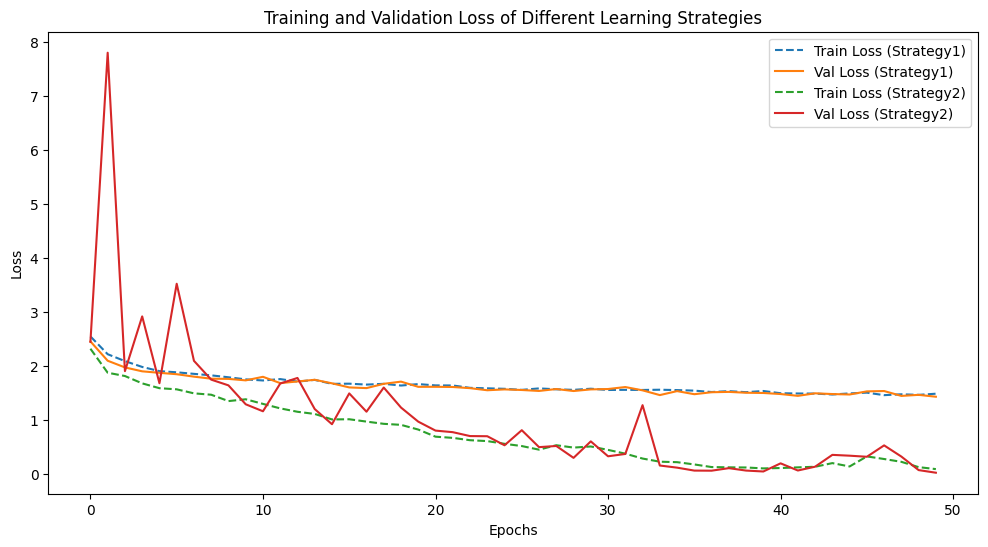

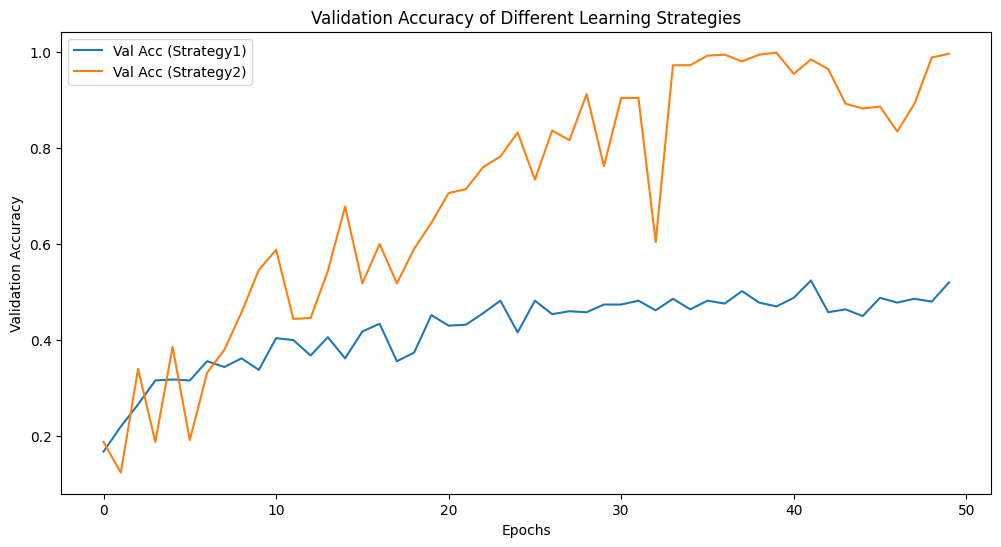

In [11]:
# Visualization
results = {}
print(f"\nTraining Strategy 1")
results[f"Strategy1"] = train_and_evaluate(model1, train_loader, test_loader, optimizer1, num_epochs)
print(f"\nTraining Strategy 2 ")
results[f"Strategy2"] = train_and_evaluate(model2, train_loader, test_loader, optimizer2, num_epochs)

# print
for key, (train_loss, val_loss, val_acc) in results.items():
    print(f"\nResults for {key}:")
    print(f"  Train Loss: {train_loss}")
    print(f"  Val Loss: {val_loss}")
    print(f"  Val Accuracy: {val_acc}")

plt.figure(figsize=(12, 6))
for key, (train_loss, val_loss, val_acc) in results.items():
    plt.plot(train_loss, label=f'Train Loss ({key})', linestyle="--")
    plt.plot(val_loss, label=f'Val Loss ({key})')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss of Different Learning Strategies")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for key, (train_loss, val_loss, val_acc) in results.items():
    plt.plot(val_acc, label=f'Val Acc ({key})')

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy of Different Learning Strategies")
plt.legend()
plt.show()

### 5. Data Augmentation
Next, we will investigate the effectiveness of data augmentation in improving model performance. To do this, we implement and compare two pre-training strategies using the CIFAR-10 dataset:

Without Data Augmentation: Train the model on CIFAR-10 without applying any augmentation techniques (as implemented in resnet50.py).
With Data Augmentation: Incorporate data augmentation techniques to train the model.

**Question 5:** For the second strategy, apply the following transformations to augment the dataset and complete the missing parts in the code:
- Random horizontal flipping with a probability of 0.5
- Random rotation up to 15 degrees

In [ ]:
"""Data Augmentation and Preprocessing"""
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flipping probability = 0.5
    transforms.RandomRotation(degrees=15),   # Rotation ±15 degrees
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

Using the aforementioned data augmentation techniques, we first pre-train the model on the CIFAR-10 dataset and save the model parameters as resnet_aug.data.
Next, we fine-tune the model on the STL-10 dataset and compare the results of the two training strategies (with and without data augmentation).

**Question 6:** Explain why data augmentation is critical for small datasets. How might these transforms improve model generalization? Are the transformations we suggested in this notebook appropriate? Would you suggest using different ones?

In [ ]:
# Fine-tune with a very small dataset
train_dataset_small = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
train_dataset_small = torch.utils.data.Subset(train_dataset_small, [i for i in range(0, 300)])
train_loader_small = DataLoader(train_dataset_small, batch_size=batch_size, shuffle=True)

# model3: without data augmentation
model3 = resnet50(num_classes=10)
model3.load_state_dict(torch.load('./resnet50.data', map_location=device), strict=False)
model3.to(device)
optimizer3 = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)

# model4: with data augmentation
model4 = resnet50(num_classes=10)
model4.load_state_dict(torch.load('./resnet50_aug.data', map_location=device), strict=False)
model4.to(device)
optimizer4 = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9)

results = {}
print(f"\nTraining Strategy 2 without augmentation ")
results[f"Strategy2_no_aug"] = train_and_evaluate(model3, train_loader_small, test_loader, optimizer3, 50)
print(f"\nTraining Strategy 2 with augmentation ")
results[f"Strategy2_aug"] = train_and_evaluate(model4, train_loader_small, test_loader, optimizer4, 50)

# print
for key, (train_loss, val_loss, val_acc) in results.items():
    print(f"\nResults for {key}:")
    print(f"  Train Loss: {train_loss}")
    print(f"  Val Loss: {val_loss}")
    print(f"  Val Accuracy: {val_acc}")

plt.figure(figsize=(12, 6))
for key, (train_loss, val_loss, val_acc) in results.items():
    plt.plot(val_acc, label=f'Val Acc ({key})')

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

**Question 7:** Can you suggest another way to perform transfer learning on these models that might be more effective than the current implementation? What would you do differently? Extra points will be given based on effort and performance of the proposed approach. You might want to consider dropping the transforms.Resize((224, 224)) operation from earlier and adjust/retrain some layers from the ResNet architecture instead as shown in class on W4S3.